                                      B2B COURIER CHARGES ACCURACY ANALYSIS

NOTE : CHECK THE README FILE BEFORE PROCEEDING

Step 1: importing the datset.

In [35]:
import pandas as pd

order_report=pd.read_csv('Order Report.csv')
sku_master=pd.read_csv('SKU Master.csv')
courier_company_rates=pd.read_csv('Courier Company - Rates.csv')
courier_invoice=pd.read_csv('Invoice.csv')
pincode_mapping=pd.read_csv('pincodes.csv')

In [36]:
print("ORDER REPORT")
print(order_report.head())
print("\nSKU MASTER")
print(sku_master.head())
print("\ncourier company rates")
print(courier_company_rates.head())
print("\ncourier invoice")
print(courier_invoice.head())
print("\npincode mapping")
print(pincode_mapping.head())

ORDER REPORT
   ExternOrderNo            SKU  Order Qty  Unnamed: 3  Unnamed: 4
0     2001827036  8904223818706        1.0         NaN         NaN
1     2001827036  8904223819093        1.0         NaN         NaN
2     2001827036  8904223819109        1.0         NaN         NaN
3     2001827036  8904223818430        1.0         NaN         NaN
4     2001827036  8904223819277        1.0         NaN         NaN

SKU MASTER
             SKU  Weight (g)  Unnamed: 2  Unnamed: 3  Unnamed: 4
0  8904223815682         210         NaN         NaN         NaN
1  8904223815859         165         NaN         NaN         NaN
2  8904223815866         113         NaN         NaN         NaN
3  8904223815873          65         NaN         NaN         NaN
4  8904223816214         120         NaN         NaN         NaN

courier company rates
   fwd_a_fixed  fwd_a_additional  fwd_b_fixed  fwd_b_additional  fwd_c_fixed  \
0         29.5              23.6           33              28.3         40.1   


CLEANING THE DATA :
1)CHECK FOR MISSING VALUES AND CLEAN THEM.
2)REMOVE DUPLICATES ALONG THE WAY 

In [37]:
print("\nMissing values in Website Order Report:")
print(order_report.isnull().sum())
print("\nMissing values in SKU Master:")
print(sku_master.isnull().sum())
print("\nMissing values in Pincode Mapping:")
print(pincode_mapping.isnull().sum())
print("\nMissing values in Courier Invoice:")
print(courier_invoice.isnull().sum())
print("\nMissing values in courier company rates:")
print(courier_company_rates.isnull().sum())


Missing values in Website Order Report:
ExternOrderNo      0
SKU                0
Order Qty          0
Unnamed: 3       400
Unnamed: 4       400
dtype: int64

Missing values in SKU Master:
SKU            0
Weight (g)     0
Unnamed: 2    66
Unnamed: 3    66
Unnamed: 4    66
dtype: int64

Missing values in Pincode Mapping:
Warehouse Pincode      0
Customer Pincode       0
Zone                   0
Unnamed: 3           124
Unnamed: 4           124
dtype: int64

Missing values in Courier Invoice:
AWB Code                0
Order ID                0
Charged Weight          0
Warehouse Pincode       0
Customer Pincode        0
Zone                    0
Type of Shipment        0
Billing Amount (Rs.)    0
dtype: int64

Missing values in courier company rates:
fwd_a_fixed         0
fwd_a_additional    0
fwd_b_fixed         0
fwd_b_additional    0
fwd_c_fixed         0
fwd_c_additional    0
fwd_d_fixed         0
fwd_d_additional    0
fwd_e_fixed         0
fwd_e_additional    0
rto_a_fixed        

In [ ]:
# Remove unnamed columns from the Website Order Report DataFrame
order_report=order_report.drop(columns=['Unnamed: 3', 'Unnamed: 4'])

# Remove unnamed columns from the SKU Master DataFrame
sku_master = sku_master.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Remove unnamed columns from the Pincode Mapping DataFrame
pincode_mapping = pincode_mapping.drop(columns=['Unnamed: 3','Unnamed: 4'])

In [45]:
# merge the order report sku master datalust for simplicity.
merged_data=pd.merge(order_report,sku_master,on='SKU')
print(merged_data.head())

   ExternOrderNo            SKU  Order Qty  Weight (g)
0     2001827036  8904223818706        1.0         127
1     2001821995  8904223818706        1.0         127
2     2001819252  8904223818706        1.0         127
3     2001816996  8904223818706        1.0         127
4     2001814580  8904223818706        1.0         127


In [47]:
# Renamed the "ExternOrderNo" column to "Order ID" in the merged_data DataFrame just for my simiplicity
merged_data = merged_data.rename(columns={'ExternOrderNo': 'Order ID'})

SINCE POSSIBILITY OF HAVING DUPLICATE CUSTOMER PINCDOE IS HIGH HENCE DROPPED THE DUPLICATE CUSTOMER PINCODE.
MERGED THE BOTH THE DATASETS.


In [57]:
#This merge operation helps us associate customer pin codes with their respective orders and shipping types. The resulting DataFrame is named ‘pincodes’.
abc_courier = pincode_mapping.drop_duplicates(subset=['Customer Pincode'])
courier_abc= courier_invoice[['Order ID', 'Customer Pincode','Type of Shipment']]
pincodes= courier_abc.merge(abc_courier,on='Customer Pincode')
print(pincodes.head())

     Order ID  Customer Pincode Type of Shipment  Warehouse Pincode Zone
0  2001806232            507101  Forward charges             121003    d
1  2001806273            486886  Forward charges             121003    d
2  2001806408            532484  Forward charges             121003    d
3  2001806458            143001  Forward charges             121003    b
4  2001807012            515591  Forward charges             121003    d


In [59]:
#let’s merge the pin codes with the main dataframe:
merged2 = merged_data.merge(pincodes, on='Order ID')

In [60]:
#Now let’s calculate the weight in kilograms by dividing the ‘Weight (g)’ column in the ‘merged2’ DataFrame by 1000:
merged2['Weights (Kgs)'] = merged2['Weight (g)'] / 1000

In [62]:
#Now let’s calculate the weight slabs:
def weight_slab(weight):
    i = round(weight % 1, 1)
    if i == 0.0:
        return weight
    elif i > 0.5:
        return int(weight) + 1.0
    else:
        return int(weight) + 0.5

merged2['Weight Slab (KG)'] = merged2['Weights (Kgs)'].apply(weight_slab)
courier_invoice['Weight Slab Charged by Courier Company']=(courier_invoice['Charged Weight']).apply(weight_slab)

The weight_slab() function is defined to determine the weight slab based on the weight of the shipment. It takes the input weight and applies certain conditions to calculate the weight slab.
in simple language approximating the weights to nearest weights.

In [63]:
courier_invoice = courier_invoice.rename(columns={'Zone': 'Delivery Zone Charged by Courier Company'})
merged2 = merged2.rename(columns={'Zone': 'Delivery Zone As Per ABC'})
merged2 = merged2.rename(columns={'Weight Slab (KG)': 'Weight Slab As Per ABC'})

The above renaming is done as per the problem statement.Now lets calculate the expected charges.


In [66]:
total_expected_charge = []

for _, row in merged2.iterrows():
    fwd_category = 'fwd_' + row['Delivery Zone As Per ABC']
    fwd_fixed = courier_company_rates.at[0, fwd_category + '_fixed']
    fwd_additional = courier_company_rates.at[0, fwd_category + '_additional']
    rto_category = 'rto_' + row['Delivery Zone As Per ABC']
    rto_fixed = courier_company_rates.at[0, rto_category + '_fixed']
    rto_additional = courier_company_rates.at[0, rto_category + '_additional']

    weight_slab = row['Weight Slab As Per ABC']

    if row['Type of Shipment'] == 'Forward charges':
        additional_weight = max(0, (weight_slab - 0.5) / 0.5)
        total_expected_charge.append(fwd_fixed + additional_weight * fwd_additional)
    elif row['Type of Shipment'] == 'Forward and RTO charges':
        additional_weight = max(0, (weight_slab - 0.5) / 0.5)
        total_expected_charge.append(fwd_fixed + additional_weight * (fwd_additional + rto_additional))
    else:
        total_expected_charge.append(0)

merged2['Expected Charge as per ABC'] = total_expected_charge
merged2.head()

,Order ID,SKU,Order Qty,Weight (g),Customer Pincode,Type of Shipment,Warehouse Pincode,Delivery Zone As Per ABC,Weights (Kgs),Weight Slab As Per ABC,Expected Charge as per ABC
0,2001827036,8904223818706,1.0,127,173213,Forward charges,121003,e,0.127,0.5,56.6
1,2001827036,8904223819093,1.0,150,173213,Forward charges,121003,e,0.150,0.5,56.6
2,2001827036,8904223819109,1.0,100,173213,Forward charges,121003,e,0.100,0.5,56.6
3,2001827036,8904223818430,1.0,165,173213,Forward charges,121003,e,0.165,0.5,56.6
4,2001827036,8904223819277,1.0,350,173213,Forward charges,121003,e,0.350,0.5,56.6


Now let’s merge it with the courier invoice to display the final dataframe:

In [69]:
merged_output = merged2.merge(courier_invoice, on='Order ID')
merged_output.head()

,Order ID,SKU,Order Qty,Weight (g),Customer Pincode_x,Type of Shipment_x,Warehouse Pincode_x,Delivery Zone As Per ABC,Weights (Kgs),Weight Slab As Per ABC,Expected Charge as per ABC,AWB Code,Charged Weight,Warehouse Pincode_y,Customer Pincode_y,Delivery Zone Charged by Courier Company,Type of Shipment_y,Billing Amount (Rs.),Weight Slab Charged by Courier Company
0,2001827036,8904223818706,1.0,127,173213,Forward charges,121003,e,0.127,0.5,56.6,1091122418320,1.6,121003,173213,b,Forward charges,117.9,2.0
1,2001827036,8904223819093,1.0,150,173213,Forward charges,121003,e,0.150,0.5,56.6,1091122418320,1.6,121003,173213,b,Forward charges,117.9,2.0
2,2001827036,8904223819109,1.0,100,173213,Forward charges,121003,e,0.100,0.5,56.6,1091122418320,1.6,121003,173213,b,Forward charges,117.9,2.0
3,2001827036,8904223818430,1.0,165,173213,Forward charges,121003,e,0.165,0.5,56.6,1091122418320,1.6,121003,173213,b,Forward charges,117.9,2.0
4,2001827036,8904223819277,1.0,350,173213,Forward charges,121003,e,0.350,0.5,56.6,1091122418320,1.6,121003,173213,b,Forward charges,117.9,2.0


Now let’s calculate the differences in charges and expected charges for each order:

In [70]:
df_diff = merged_output
df_diff['Difference (Rs.)'] = df_diff['Billing Amount (Rs.)'] - df_diff['Expected Charge as per ABC']

df_new = df_diff[['Order ID', 'Difference (Rs.)', 'Expected Charge as per ABC']]

print(df_new.head())

     Order ID  Difference (Rs.)  Expected Charge as per ABC
0  2001827036              61.3                        56.6
1  2001827036              61.3                        56.6
2  2001827036              61.3                        56.6
3  2001827036              61.3                        56.6
4  2001827036              61.3                        56.6


let’s summarize the accuracy of B2B courier charges based on the charged prices and expected prices:

In [71]:
# Calculate the total orders in each category
total_correctly_charged = len(df_new[df_new['Difference (Rs.)'] == 0])
total_overcharged = len(df_new[df_new['Difference (Rs.)'] > 0])
total_undercharged = len(df_new[df_new['Difference (Rs.)'] < 0])

# Calculate the total amount in each category
amount_overcharged = abs(df_new[df_new['Difference (Rs.)'] > 0]['Difference (Rs.)'].sum())
amount_undercharged = df_new[df_new['Difference (Rs.)'] < 0]['Difference (Rs.)'].sum()
amount_correctly_charged = df_new[df_new['Difference (Rs.)'] == 0]['Expected Charge as per ABC'].sum()

# Create a new DataFrame for the summary
summary_data = {'Description': ['Total Orders where ABC has been correctly charged',
                                'Total Orders where ABC has been overcharged',
                                'Total Orders where ABC has been undercharged'],
                'Count': [total_correctly_charged, total_overcharged, total_undercharged],
                'Amount (Rs.)': [amount_correctly_charged, amount_overcharged, amount_undercharged]}

df_summary = pd.DataFrame(summary_data)

print(df_summary)

                                         Description  Count  Amount (Rs.)
0  Total Orders where ABC has been correctly charged     12         507.6
1        Total Orders where ABC has been overcharged    382       33750.5
2       Total Orders where ABC has been undercharged      7        -165.2


We can also visualize the proportion of errors. I will be usingpie chart to do so. Here it is :

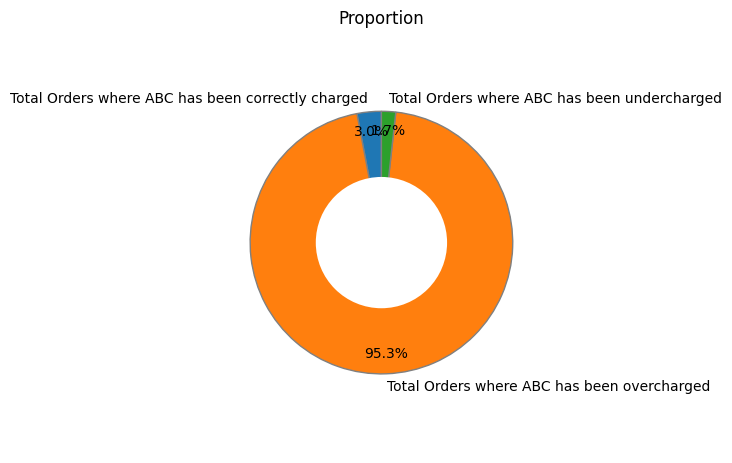

In [103]:
import matplotlib.pyplot as plt
labels = df_summary['Description']
values = df_summary['Count']

# Create a donut pie chart
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops={'edgecolor': 'grey'})

# Draw a white circle in the center to create the donut effect
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Set title
plt.title('Proportion')

# Display the plot
plt.tight_layout()
plt.show()